## Label Clustering

Perform label simplification (singularization/lemmatization) and label clustering

In [2]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

from bertopic import BERTopic
from umap import UMAP

import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')      
nltk.download('wordnet')    
nltk.download('omw-1.4') 
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /Users/david/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/david/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Load data

In [9]:
filepath = "/Users/david/Desktop/Research/Project/Data/Application/clean_datasets"

cates = [
    'ukraine', 
    'immigration',
    'tech_and_jobs',
    'samesex', 
    'climate'
]

dfs = {cate: pd.read_csv(os.path.join(filepath, "character_labels_data", f"{cate}.csv")) for cate in cates}

# merge all datasets together (with the selected columns only)
sel_cols = [
    'orig_index',
    'character',
    'base_label',
    'modifier',
    'full_label',
    'hero_type',
    'cate'
]

for cate, df in dfs.items():
    df['cate'] = cate
    dfs[cate] = df

df = pd.concat([df[sel_cols] for _, df in dfs.items()])

#### 1) Simplify labels

Correct base label mistakes (labels with more than 2 words)

In [3]:
base_labels_to_split = [
    'ally', 
    'authority', 
    'leader', 
    'partner', 
    'adversary', 
    'giant', 
    'nation', 
    'driver', 
    'tool', 
    'advocate', 
    'institution',
    'strategist',
    'collaborator',
    'researcher'
]

# Identify mistakes
mistake_labels = df['base_label'].apply(
    lambda x: (len(x.split()) > 1) and (x.split()[1] in base_labels_to_split)
)

# Make corrections
df['corr_base_label'] = df['base_label']
df['corr_modifier'] = df['modifier']
df.loc[mistake_labels, 'corr_base_label'] = df.loc[mistake_labels, 'base_label'].apply(lambda x: x.split()[1])
df.loc[mistake_labels, 'corr_modifier'] = df.loc[mistake_labels, 'modifier'] + " " + df.loc[mistake_labels, 'base_label'].apply(lambda x: x.split()[0])

Singularize base labels and lemmatize modifiers

In [4]:
# Singularize nouns
df['corr_base_label'] = df['corr_base_label'].apply(lambda x: lemmatizer.lemmatize(x, pos='n'))

# Lemmatize modifiers
df['corr_modifier'] = df['corr_modifier'].apply(lambda x: " ".join([lemmatizer.lemmatize(j, pos='a') for j in x.split()]))

# Form full labels
df['corr_full_label'] = df['corr_modifier'] + " " + df['corr_base_label']


#### 2) Cluster

In [5]:
# determine the optimal clustering threshold for agglomerative clustering using Silhouette score
def get_optimal_clustering_threshold(orig_docs: pd.Series, emb_model: SentenceTransformer, show_plot: bool = False):
    docs = orig_docs.unique()

    # get embeddings
    embs = emb_model.encode(docs, convert_to_tensor=True).to('cpu')

    # compute pairwise distances and perform clustering
    pairwise_dists = pdist(embs, metric='cosine')
    Z = linkage(pairwise_dists, method='complete')

    # scan through the distance thresholds and compute the Silhouette scores
    t_vals = np.arange(start=0.2, stop=1, step=0.01).round(2)
    silhouette_scores = []
    print("Scanning thresholds...")
    for t in tqdm(t_vals):
        clusters = fcluster(Z, t=t, criterion='distance')
        silhouette_scores.append(silhouette_score(embs, clusters, metric='cosine'))

    optimal_threshold = t_vals[np.array(silhouette_scores).argmax()]
    print(f"Optimal threshold: {optimal_threshold}")

    # plot Silhouette scores
    if show_plot:
        ax = plt.subplot()
        plt.scatter(t_vals, silhouette_scores, label='Silhouette')
        plt.ylabel("Score")
        plt.xlabel("Distance Threshold")
        plt.legend(prop={'size': 12}) #, bbox_to_anchor=(1.05, 1), loc='upper left')
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(15)
        plt.show()

    return optimal_threshold

# get the entry -> cluster name mapping when clustering using agglomerative clustering with the specified threshold
def get_cluster_name_mapping(orig_docs, dist_thres):
    # remove duplicates
    docs = orig_docs.unique()

    # get topics
    topic_model, topics = get_topic_model(docs, model_name, dist_thres)
    topic_df = pd.DataFrame(data={'entry': docs, 'topic': topics}).sort_values('topic')

    # normalize cluster names (map entry to the most frequent entry in each cluster)
    full_topic_df = orig_docs.rename('entry').to_frame().merge(topic_df)          # topic df with duplicates
    standard_label_names = (full_topic_df.groupby('topic')['entry']
        .apply(lambda x: x.value_counts().index[0])
        .rename("standard_entry")
        .to_frame()
    )
    full_topic_df = full_topic_df.merge(standard_label_names, on='topic')

    # get entry to cluster name mapping
    cluster_name_mapping = full_topic_df[['entry', 'standard_entry']].set_index('entry')['standard_entry'].to_dict()

    return cluster_name_mapping

class NoUMAP(UMAP):
    def fit(self, X):
        return X
    def transform(self, X):
        return X

# Compute a topic model using agglomeratice clustering with no UMAP
def get_topic_model(docs, model_name, dist_thres):
    topic_model = BERTopic(
        embedding_model = model_name,
        umap_model = NoUMAP(),
        hdbscan_model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=dist_thres, metric='cosine'),
        vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1,1)),
    )
    topics, _ = topic_model.fit_transform(docs)
    return topic_model, topics

In [6]:
# Embedding model
models = [
    "stsb-mpnet-base-v2",
    "nli-mpnet-base-v2",
    "average_word_embeddings_glove.6B.300d",
    "stsb-roberta-base-v2"
]
model_name = models[3]
emb_model = SentenceTransformer(model_name)

Determine the optimal thresholds

corr_base_label
Scanning thresholds...


100%|██████████| 80/80 [00:09<00:00,  8.35it/s]


Optimal threshold: 0.54


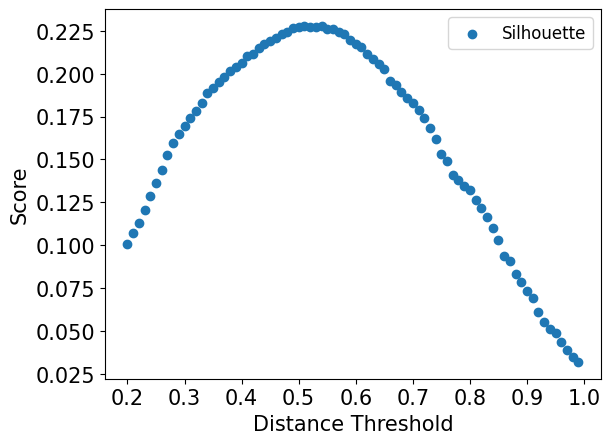

corr_modifier
Scanning thresholds...


100%|██████████| 80/80 [01:18<00:00,  1.02it/s]

Optimal threshold: 0.52


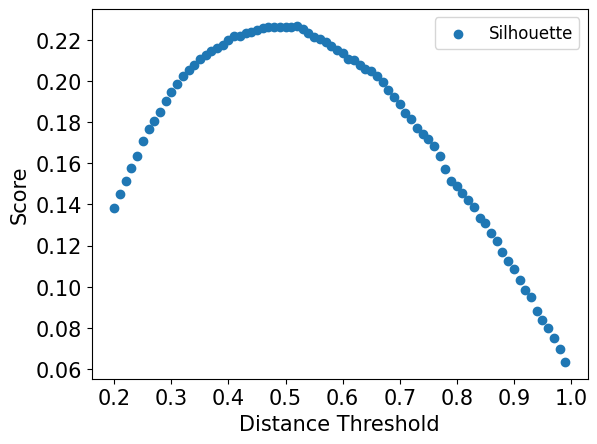

In [7]:
optimal_dist_thresholds = dict()
for label_type in ['corr_base_label', 'corr_modifier']:
    print(label_type)
    optimal_dist_thresholds[label_type] = get_optimal_clustering_threshold(df[label_type], emb_model, show_plot=True)

Compute clusters

In [8]:
base_label_mapping = get_cluster_name_mapping(df['corr_base_label'], optimal_dist_thresholds['corr_base_label'])
modifier_mapping = get_cluster_name_mapping(df['corr_modifier'], optimal_dist_thresholds['corr_modifier'])

In [9]:
df['clustered_base_label'] = df['corr_base_label'].apply(lambda x: base_label_mapping[x])
df['clustered_modifier'] = df['corr_modifier'].apply(lambda x: modifier_mapping[x])
df['clustered_full_label'] = df['clustered_modifier'] + " " + df['clustered_base_label']

In [24]:
# save
df.to_csv(os.path.join(filepath, "clustered_labels.csv"), index=False)

### Labelling Stats

In [ ]:
label_types = ['base_label', 'modifier', 'full_label']
dfs = []
for col in label_types:
    df_tmp = df.groupby('cate')[[col, f'clustered_{col}']].nunique()
    dfs.append(df_tmp)
df_label_stats = pd.concat(dfs, axis=1).rename(columns={
    'base_label': "Original PRIM",
    'modifier': 'Original MOD',
    'full_label': "Original Full",
    "clustered_base_label": "PRIM",
    "clustered_modifier": "MOD",
    "clustered_full_label": "Full"
})
df_label_stats

,Original PRIM,PRIM,Original MOD,MOD,Original Full,Full
cate,,,,,,
climate,1440,728,3124,1576,9120,7715
immigration,1779,843,3754,1870,10525,9044
samesex,1265,670,2590,1400,8126,6775
tech_and_jobs,1089,649,3223,1730,6382,5803
ukraine,479,330,815,631,1866,1777


In [22]:
df_label_stats.sum().to_frame().T

,Original PRIM,PRIM,Original MOD,MOD,Original Full,Full
0,6052,3220,13506,7207,36019,31114
